<a href="https://colab.research.google.com/github/eubielaraujo/MalariaDiagnosisCNN/blob/main/Malaria_Diagnosis_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive

# Data Loading and Preparation

In [ ]:
dataset, dataset_info = tfds.load(
    "malaria", with_info=True, shuffle_files=True)

In [3]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_ds = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
  val_test_ds = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_ds = val_test_ds.take(int(VAL_RATIO*DATASET_SIZE))
  test_ds = val_test_ds.skip(int(TEST_RATIO*DATASET_SIZE))

  return train_ds, val_ds, test_ds

In [4]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_ds, val_ds, test_ds = split(dataset['train'], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [5]:
train_ds

<_TakeDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [6]:
def get_label_str(label):
  if label == 0:
    return 'Parasitized'
  else:
    return 'Uninfected'

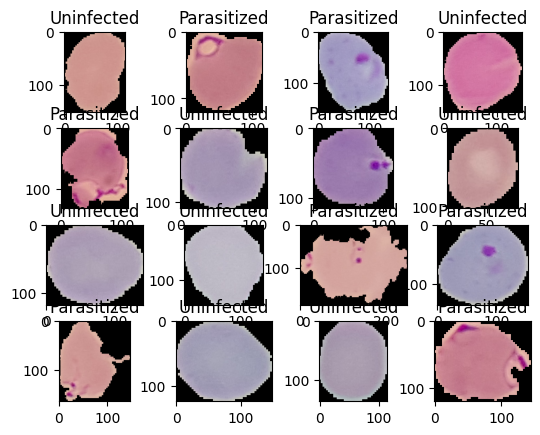

In [7]:
for i, sample in enumerate(train_ds.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(sample['image'])
  plt.title(get_label_str(sample['label'].numpy()))

In [8]:
IM_SIZE = 224
BATCH_SIZE = 32

In [9]:
def resize_rescale(data):
  image = data['image']
  label = data['label']

  # exemplo de preprocessamento
  image = tf.image.resize(image, (IM_SIZE, IM_SIZE))
  image = image / 255.0

  return image, label

In [10]:
train_dataset = train_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [70]:
np.unique(image)

array([0.0000000e+00, 1.7794440e-05, 1.9326864e-05, ..., 9.2830914e-01,
       9.2855394e-01, 9.3057460e-01], dtype=float32)

# Model Creation and Training

In [62]:
model = tf.keras.Sequential([
 InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

 Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
 BatchNormalization(),
 MaxPool2D(pool_size = 2, strides = 2),

 Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
 BatchNormalization(),
 MaxPool2D(pool_size = 2, strides = 2),

 Flatten(),

 Dense(100, activation='relu'),
 BatchNormalization(),
 Dense(10, activation='relu'),
 BatchNormalization(),
 Dense(1, activation = 'sigmoid'),

])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [63]:
model.compile(
    optimizer = Adam(learning_rate = 0.01),
    loss = BinaryCrossentropy(),
    metrics = [BinaryAccuracy()],
)

In [15]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 100,
    verbose = 1
)

Epoch 1/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 56s 64ms/step - binary_accuracy: 0.7754 - loss: 0.4558 - val_binary_accuracy: 0.9365 - val_loss: 0.1974
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - binary_accuracy: 0.9313 - loss: 0.1996 - val_binary_accuracy: 0.7361 - val_loss: 0.4347
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - binary_accuracy: 0.9456 - loss: 0.1683 - val_binary_accuracy: 0.9172 - val_loss: 0.4130
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - binary_accuracy: 0.9519 - loss: 0.1495 - val_binary_accuracy: 0.9005 - val_loss: 0.4530
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - binary_accuracy: 0.9536 - loss: 0.1435 - val_binary_accuracy: 0.9031 - val_loss: 0.4397
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - binary_accuracy: 0.9565 - loss: 0.1357 - val_binary_accuracy: 0.9151 - val_loss: 0.3787
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - binary_accuracy: 0.9590 - loss: 0.1264 - val_binary_accuracy: 0.9339 - va

# Model Evaluation and Testing

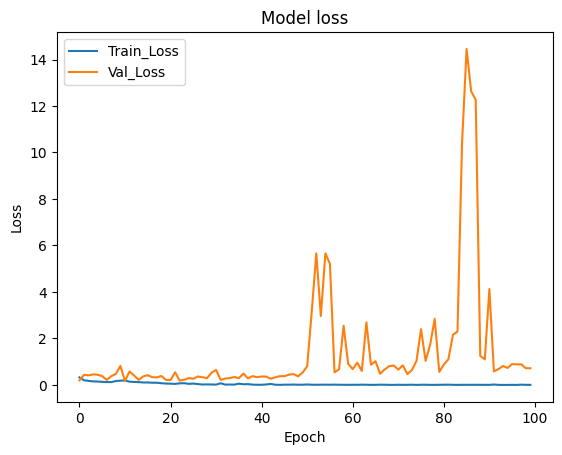

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_Loss', 'Val_Loss'])
plt.show()

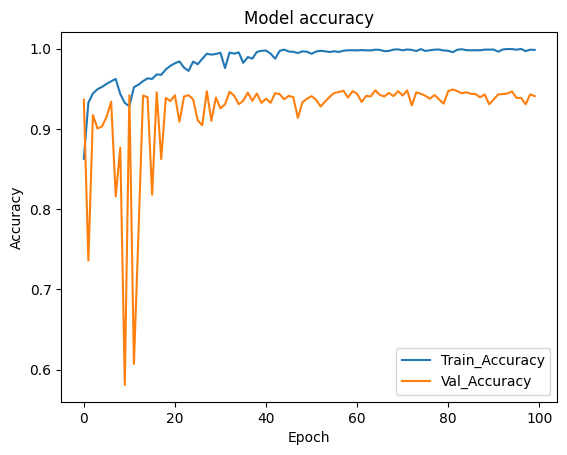

In [17]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_Accuracy', 'Val_Accuracy'])
plt.show()

In [66]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - binary_accuracy: 0.9364 - loss: 0.6334


[0.5507385730743408, 0.9343489408493042]

In [22]:
def parasite_or_not(x):
  if x < 0.5:
    return str('P')
  else:
    return str('U')

In [29]:
print(parasite_or_not(model.predict(test_dataset.take(1))[0][0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
U


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


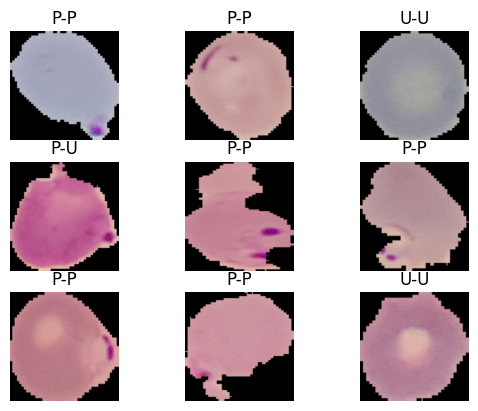

In [34]:
for image,label in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[i])
    plt.title(parasite_or_not(label.numpy()[i])+"-"+parasite_or_not(model.predict(image)[i][0]))
    plt.axis('off')

# Saving Model

In [48]:
model.save("MalariaSavedModel.keras")

In [59]:
os.mkdir("weights")
model.save_weights("weights/Malaria.weights.h5")

In [68]:
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
!cp -r /content/model/ /content/drive/MyDrive/MalariaModel